# RQ 1.
What effect replacing SoftMax based classifier to a set of one-vs-all classifier (OvRs) have on
- the closed-set performance (OvRs vs. Categorical Cross Entropy)
- the open-set performance (OvRs vs. Categorical Cross Entropy)

of multiclass classification task?


[Scikit learn : Classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import os
import re
import itertools
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl

from library import architectures, tools, evals, dataset, losses

In [57]:
arch = 'LeNet_plus_plus'
scale = 'SmallScale'
approaches = ['SoftMax','EOS','OvR','OpenSetOvR']
approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Classifiers','OpenSetOvR':'Open-Set One-vs-Rest Classifiers'}
seeds = [42,43,44,45,46,47,48,49,50,51]
# seeds = [42] * 10
num_classes = 10

CMAP = mpl.color_sequences['tab10']

## Functions

In [58]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [59]:
class eval_results():
    def __init__(self, folder_path):

        self.test_neg_gt = np.load(os.path.join(folder_path, 'pred', 'test_neg_gt.npy'))
        self.test_neg_logits = np.load(os.path.join(folder_path, 'pred', 'test_neg_logits.npy'))
        self.test_neg_probs = np.load(os.path.join(folder_path, 'pred', 'test_neg_probs.npy'))

        self.test_unkn_gt = np.load(os.path.join(folder_path, 'pred', 'test_unkn_gt.npy'))
        self.test_unkn_logits = np.load(os.path.join(folder_path, 'pred', 'test_unkn_logits.npy'))
        self.test_unkn_probs = np.load(os.path.join(folder_path, 'pred', 'test_unkn_probs.npy'))

        self.ccr = np.load(os.path.join(folder_path, 'oscr', 'ccr.npy'))
        self.fpr_neg = np.load(os.path.join(folder_path, 'oscr', 'fpr_neg.npy'))
        self.fpr_unkn = np.load(os.path.join(folder_path, 'oscr', 'fpr_unkn.npy'))


In [60]:
def recall_oscr_results(which='OvR', arch='LeNet_plus_plus', dataset='SmallScale', seed=-1, is_verbose=True):
    if seed == -1:
        root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}/{which}/oscr'
    else:
        root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/_s{seed}/eval_{arch}/{which}/oscr'
    if is_verbose:
        print(root_path, which)
    oscr_results = [
        np.load(os.path.join(root_path,'ccr.npy')),
        np.load(os.path.join(root_path,'fpr_neg.npy')),
        np.load(os.path.join(root_path,'fpr_unkn.npy')),
        ]
    return oscr_results

In [61]:
def CCR_at_FPR(CCR, FPR, fpr_values=[1e-4,1e-3,1e-2,1e-1,1]):
    """Computes CCR values for the desired FPR values, if such FPR values can be reached."""

    ccrs = []
    zero = np.zeros(FPR.shape)
    for desired_fpr in fpr_values:
        # get the FPR value that is closest, but above the current threshold
        candidates = np.nonzero(np.maximum(desired_fpr - FPR, zero))[0]
        if len(candidates) > 0:
            # there are values above threshold
            ccrs.append(CCR[candidates[0]])
        else:
            # the desired FPR cannot be reached
            ccrs.append(np.nan)

    return ccrs, fpr_values

In [62]:
def deep_feat_viz_all(gt, feats, appr, seed, arch):

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    max_val = np.max(np.abs(feats[gt!=-1]))
    xy_range = [-max_val, max_val]
    for i in range(10):
        feats_c = feats[gt == i,:]
        # if i in [0,1,2,3,4,5,6,7,8,9]:
        ax[0].scatter(feats_c[:,0], feats_c[:,1], label = i, s=100 if i==-1 else 1, color=CMAP[i])
        # print(np.min(feats_c,axis=0), np.max(feats_c,axis=0))
        # print(np.mean(probs_c), np.std(probs_c), np.max(probs_c))
    ax[0].set_title(f'{appr} Known Samples')
    ax[0].set_xlabel('f1')
    ax[0].set_xlim(xy_range[0],xy_range[1])
    ax[0].set_ylabel('f2')
    ax[0].set_ylim(xy_range[0],xy_range[1])

    ax[0].legend()
    ax[0].grid(True)

    network_file = f'_models/SmallScale/_s{seed}/{arch}/{appr}/{appr}.model'
    checkpoint = torch.load(network_file, map_location=torch.device('cpu')) 
    for i,w in enumerate(checkpoint['fc2.weight']):
        a,b = w
        # print(i, 1/np.sqrt(a**2 + b**2))
        slope = -1 * (a.item() / b.item())
        # print(slope)
        x = np.linspace(xy_range[0],xy_range[1],1000)
        y = slope * x
        # if i in [0,1,2,3,4,5,6,7,8,9]:
        ax[1].plot(x,y,label=i, color=CMAP[i])

    ax[1].set_title(f'{appr} Decision Boundary')
    ax[1].set_xlabel('f1')
    ax[1].set_xlim(xy_range[0],xy_range[1])
    ax[1].set_ylabel('f2')
    ax[1].set_ylim(xy_range[0],xy_range[1])
    ax[1].legend()
    ax[1].grid(True)

    fig.tight_layout()

    return xy_range

In [70]:
def deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls = [0,1,2,3,4,5,6,7,8,9]):
    
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    max_val = np.max(np.abs(feats[np.isin(gt, cls)]))
    xy_range = [-max_val, max_val]

    # Heatmap data
    net = architectures.__dict__['LeNet_plus_plus'](use_BG=False,
                                            num_classes=10,
                                            final_layer_bias=False,)
    network_file = f'_models/SmallScale/_s{seed}/{arch}/{appr}/{appr}.model'
    checkpoint = torch.load(network_file, map_location=torch.device('cpu')) 
    net.load_state_dict(checkpoint)
    x = np.linspace(xy_range[0] * 1.5, xy_range[1] * 1.5, 1000)
    y = np.linspace(xy_range[0] * 1.5, xy_range[1] * 1.5, 1000)
    pnts = list(itertools.chain(itertools.product(x, y)))
    pnts = np.array(pnts)
    pnts = torch.tensor(pnts).float()
    result = net.deep_feature_forward(pnts)
    if appr == 'OvR':
        probs = F.sigmoid(result).detach()
    elif appr == 'OpenSetOvR':
        osovr_act = losses.OpenSetOvR(sigma)
        norm = True
        if arch == 'LeNet_plus_plus_NotNormalized':
            norm = False
        probs = osovr_act(result, net.fc2.weight.data, norm=norm).detach()
    else:
        probs = F.softmax(result, dim=1).detach()
    probs = torch.max(probs, dim=1).values

    heat_map = ax.pcolormesh(
        x,
        y,
        np.array(probs).reshape(1000, 1000).transpose(),
        cmap='gray',
        rasterized=True,
        shading="auto",
        vmin=0.0,
        vmax=1.0,
    )

    # Known sample scatter plot
    for i in range(10):
        if i in cls:
            feats_c = feats[gt == i,:]
            ax.scatter(feats_c[:,0], feats_c[:,1], label = i, s=100 if i==-1 else 1, color=CMAP[i], marker='*')

    # Decision boundary plot
    for i,w in enumerate(checkpoint['fc2.weight']):
        if i in cls:
            a,b = w
            slope = -1 * (a.item() / b.item())
            x = np.linspace(xy_range[0],xy_range[1],1000)
            y = slope * x
            ax.plot(x,y,color=CMAP[i])

    ax.set_title(f'Known Samples w/t Decision Boundary')
    ax.set_xlabel('f1')
    ax.set_xlim(xy_range[0],xy_range[1])
    ax.set_ylabel('f2')
    ax.set_ylim(xy_range[0],xy_range[1])
    ax.legend()
    ax.grid(True)

    fig.colorbar(heat_map, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()

In [72]:
def deep_feat_viz_dc_progress(appr, seed, arch, sigma, xy_range=[-1000,1000]):
    
    # Find all check points
    network_folder = f'_models/SmallScale/_s{seed}/{arch}/{appr}'

    models = list_model_files(network_folder)
    models = [m for m in models if re.compile(r'_\d').search(m)]
    models.sort(key=lambda f: int(re.sub('\D', '', f)))

    num_r = int(np.ceil(len(models)/5))
    num_c = 5
    fig, ax = plt.subplots(num_r,num_c,figsize=(num_c*4,num_r*4), sharex=True, sharey=True)

    for idx, m in enumerate(models):

        i,j = idx // num_c, idx% num_c

        network_file = os.path.join(network_folder, m)

        # Collecting heatmap data
        net = architectures.__dict__['LeNet_plus_plus'](use_BG=False,
                                                num_classes=10,
                                                final_layer_bias=False,)
        checkpoint = torch.load(network_file, map_location=torch.device('cpu')) 
        net.load_state_dict(checkpoint)

        x = np.linspace(xy_range[0] * 1.5, xy_range[1] * 1.5, 1000)
        y = np.linspace(xy_range[0] * 1.5, xy_range[1] * 1.5, 1000)

        pnts = list(itertools.chain(itertools.product(x, y)))
        pnts = np.array(pnts)
        pnts = torch.tensor(pnts).float()
        logits = net.deep_feature_forward(pnts)
        if appr == 'OvR':
            probs = F.sigmoid(logits).detach()
        elif appr == 'OpenSetOvR':
            osovr_act = losses.OpenSetOvR(sigma)
            norm = True
            if arch == 'LeNet_plus_plus_NotNormalized':
                norm = False
            probs = osovr_act(logits, net.fc2.weight.data, norm=norm).detach()
        else:
            probs = F.softmax(logits, dim=1).detach()
        probs = torch.max(probs, dim=1).values

        # Plotting heatmap data
        heat_map = ax[i,j].pcolormesh(
            x,
            y,
            np.array(probs).reshape(1000, 1000).transpose(),
            cmap='gray',
            rasterized=True,
            shading="auto",
            vmin=0.0,
            vmax=1.0,
        )

        # Plotting decision boundaries for each classs
        for c,w in enumerate(checkpoint['fc2.weight']):
            a,b = w
            # print(i, 1/np.sqrt(a**2 + b**2))
            slope = -1 * (a.item() / b.item())
            # print(slope)
            y = slope * x
            ax[i,j].plot(x,y, color=CMAP[c])
                
        ax[i,j].set_title(f'{m}')
        ax[i,j].set_xlim(xy_range[0],xy_range[1])
        ax[i,j].set_ylim(xy_range[0],xy_range[1])
        ax[i,j].grid(True)

    fig.suptitle('Feature space progress')
    fig.tight_layout()

## Feature Space Viz

In [65]:
seed = 42
arch = 'LeNet_plus_plus_NotNormalized'
appr = 'OpenSetOvR' # SoftMax EOS OvR OpenSetOvR
eval_root = f'/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s{seed}/eval_{arch}/{appr}'

sigma = 6

In [66]:
feats = np.load(os.path.join(eval_root,'pred','train_feats.npy'))
gt = np.load(os.path.join(eval_root,'pred','train_gt.npy'))
probs = np.load(os.path.join(eval_root,'pred','train_probs.npy'))
logits = np.load(os.path.join(eval_root,'pred','train_logits.npy'))
preds = np.argmax(probs,axis=1)

print(eval_root)
print(feats.shape, gt.shape, probs.shape, logits.shape, preds.shape)


/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus_NotNormalized/OpenSetOvR
(90240, 2) (90240,) (90240, 10) (90240, 10) (90240,)


[-5392.67431640625, 5392.67431640625]


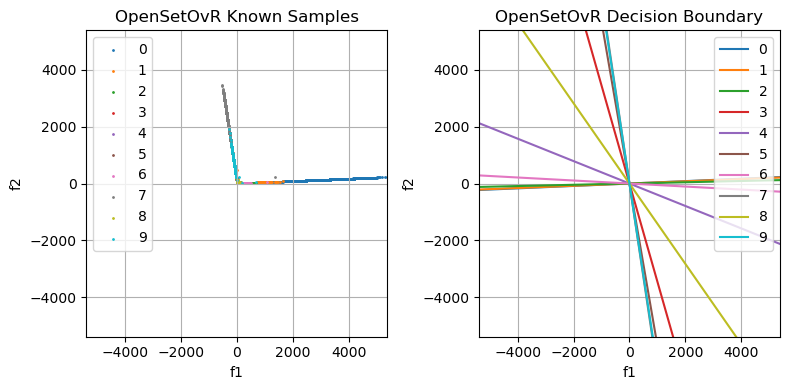

In [67]:
xy_range = deep_feat_viz_all(gt, feats, appr, seed, arch)
print(xy_range)

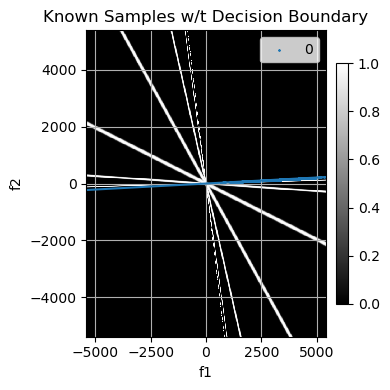

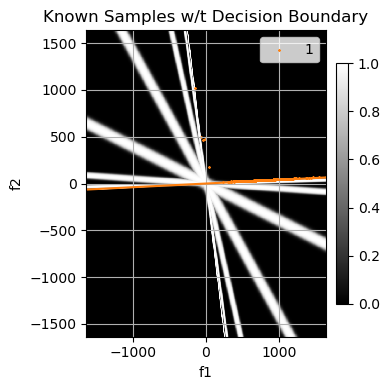

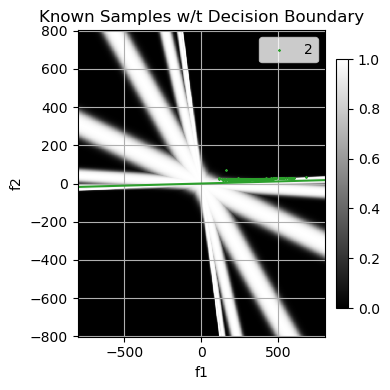

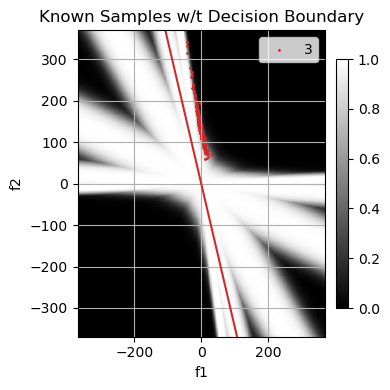

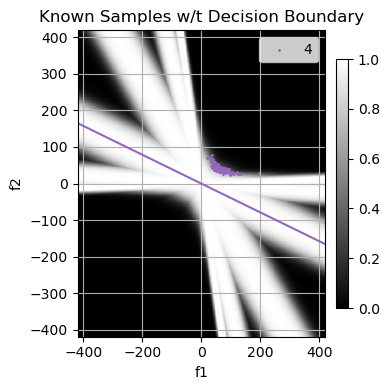

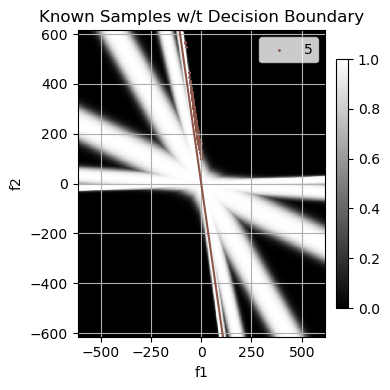

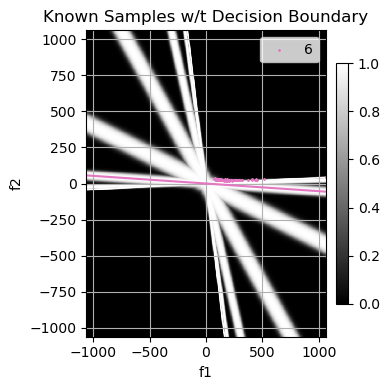

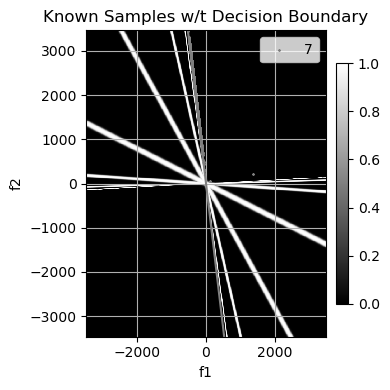

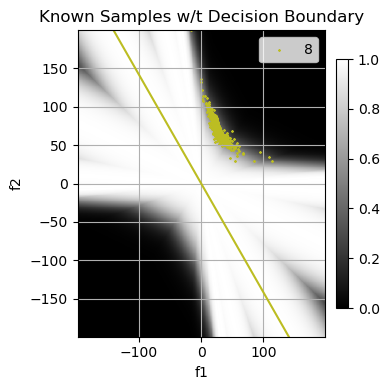

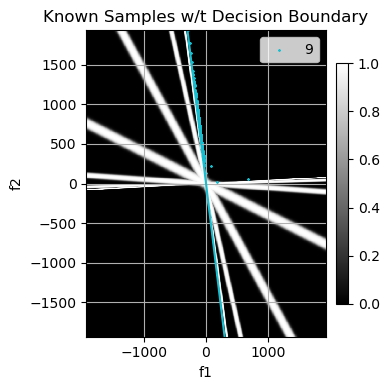

In [71]:
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[0])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[1])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[2])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[3])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[4])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[5])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[6])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[7])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[8])
deep_feat_viz_class(gt, feats, arch, appr, seed, sigma, cls=[9])

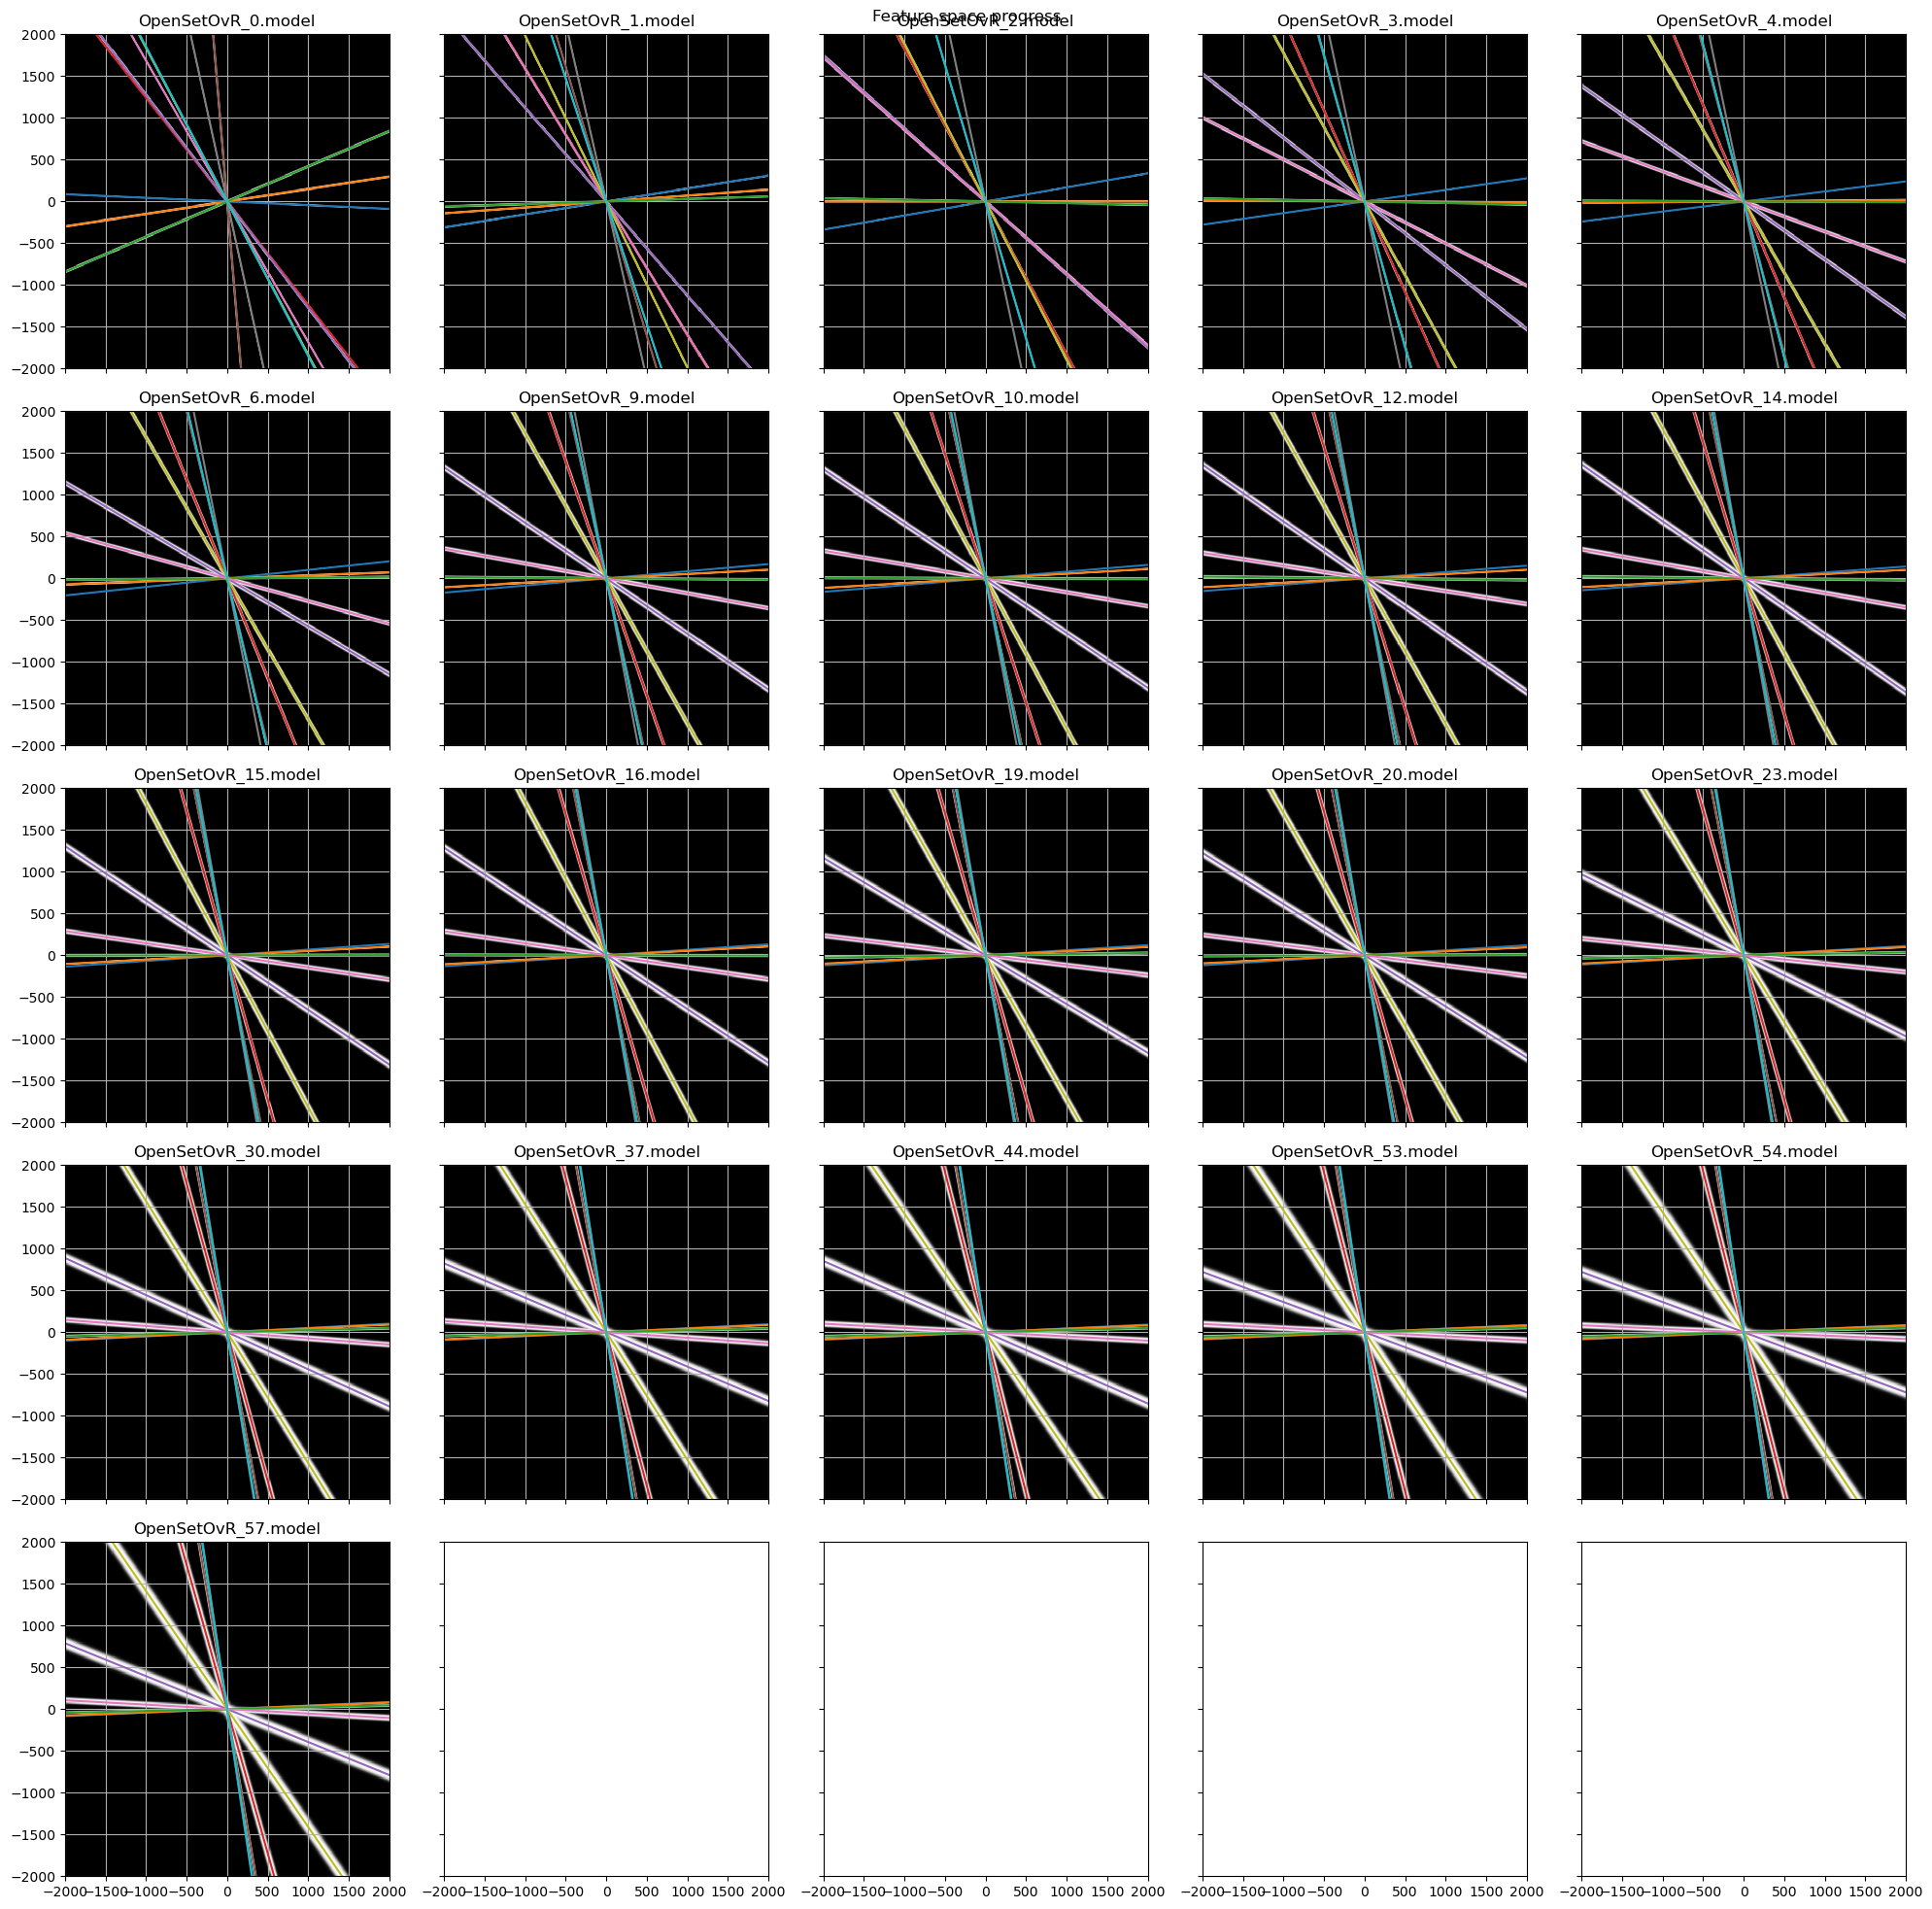

In [75]:
deep_feat_viz_dc_progress(appr, seed, arch, sigma, xy_range=xy_range)

In [ ]:
# Not able to execute because the rolf server access is denied.
# deep_feat_viz_sample_progress(appr, seed, arch, scale, is_verbose=True)

## Closed-set accuracy

### Multi-class Accuracy

In [25]:
df = pd.DataFrame(index=[approaches_abbr[a] for a in approaches], columns=[f"s{s}" for s in seeds])

for idx, s in enumerate(seeds):
    results = []
    for a in approaches:

        # Retrieve evaluation result
        folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
        eval = eval_results(folder_path)

        # Leave only known samples
        knowns = eval.test_neg_gt != -1
        unknowns = ~knowns
        y_true = eval.test_neg_gt[knowns]
        y_pred = np.argmax(eval.test_neg_probs[knowns], axis=1)

        # Calculate multiclass accuracry
        acc = metrics.accuracy_score(y_true, y_pred)
        results.append(acc)
    df.iloc[:,idx] = results

print(df)

          s42     s43     s44     s45     s46     s47     s48     s49     s50  \
SM     0.9905  0.9912  0.9917   0.989  0.9915  0.9894  0.9906  0.9916  0.9895   
EOS    0.9864  0.9872  0.9873  0.9883  0.9878  0.9849  0.9865  0.9874  0.9856   
OvR    0.5942  0.5028  0.6633  0.5883  0.6467  0.4949  0.5837   0.592  0.5932   
OSOvR  0.9918  0.9902  0.9895  0.9915   0.989  0.9898  0.9891  0.9908  0.9867   

          s51  
SM     0.9921  
EOS    0.9874  
OvR    0.5979  
OSOvR  0.9899  


### Multi-class Balanced Accuracry

In [26]:
df = pd.DataFrame(index=[approaches_abbr[a] for a in approaches], columns=[f"s{s}" for s in seeds])

for idx, s in enumerate(seeds):
    results = []
    for a in approaches:

        # Retrieve evaluation result
        folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
        eval = eval_results(folder_path)

        # Leave only known samples
        knowns = eval.test_neg_gt != -1
        unknowns = ~knowns
        y_true = eval.test_neg_gt[knowns]
        y_pred = np.argmax(eval.test_neg_probs[knowns], axis=1)

        # Calculate multiclass accuracry
        acc = metrics.balanced_accuracy_score(y_true, y_pred)
        results.append(acc)
    df.iloc[:,idx] = results

print(df)

          s42     s43     s44     s45     s46     s47     s48     s49     s50  \
SM     0.9905  0.9912  0.9917   0.989  0.9915  0.9894  0.9906  0.9916  0.9895   
EOS    0.9864  0.9872  0.9873  0.9883  0.9878  0.9849  0.9865  0.9874  0.9856   
OvR    0.5942  0.5028  0.6633  0.5883  0.6467  0.4949  0.5837   0.592  0.5932   
OSOvR  0.9918  0.9902  0.9895  0.9915   0.989  0.9898  0.9891  0.9908  0.9867   

          s51  
SM     0.9921  
EOS    0.9874  
OvR    0.5979  
OSOvR  0.9899  


### One-vs-Rest Accuracy

In [27]:
for a in approaches: 
    df = pd.DataFrame(index=[f"c{c}" for c in range(num_classes)], columns=[f"s{s}" for s in seeds])
    for idx, s in enumerate(seeds):

        # Retrieve evaluation result
        folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
        eval = eval_results(folder_path)

        # Leave only known samples
        knowns = eval.test_neg_gt != -1
        unknowns = ~knowns
        y_true = eval.test_neg_gt[knowns]
        y_probs = np.argmax(eval.test_neg_probs[knowns], axis=1)
        # print(y_true.shape, y_probs.shape)
        results = []
        for c in range(num_classes):
            y_true_c = y_true == c
            y_pred_c = y_probs == c
            # print(y_true_c.shape, y_pred_c.shape)
            acc = metrics.accuracy_score(y_true_c, y_pred_c)
            results.append(acc)
            # print(f"{arch} {scale} {a} | accuracy (micro) : {np.mean(acc_scores):.5f} {np.std(acc_scores):.5f}")
            # print(arch, scale, a, np.mean(acc_scores), np.std(acc_scores))
        df.iloc[:,idx] = results
    print(approaches_abbr[a])
    print(df)
    print()

SM
       s42     s43     s44     s45     s46     s47     s48     s49     s50  \
c0  0.9986  0.9984  0.9988  0.9978  0.9986   0.999  0.9989  0.9989  0.9986   
c1  0.9987  0.9993  0.9986  0.9985  0.9992  0.9993  0.9987  0.9996  0.9976   
c2  0.9977  0.9981  0.9982  0.9977   0.998  0.9979  0.9978  0.9978   0.998   
c3  0.9982  0.9982  0.9982  0.9975  0.9981  0.9973  0.9979  0.9979  0.9976   
c4  0.9977  0.9982  0.9981  0.9976  0.9982   0.998  0.9981  0.9975  0.9979   
c5  0.9987  0.9976  0.9988  0.9973  0.9986  0.9975  0.9982   0.998  0.9976   
c6  0.9985  0.9991  0.9986  0.9994   0.999  0.9987  0.9983  0.9991  0.9988   
c7  0.9974  0.9975  0.9987  0.9972  0.9984  0.9979  0.9974  0.9986  0.9982   
c8  0.9975  0.9975  0.9976  0.9974  0.9974  0.9967  0.9982   0.998  0.9974   
c9   0.998  0.9985  0.9978  0.9976  0.9975  0.9965  0.9977  0.9978  0.9973   

       s51  
c0  0.9988  
c1  0.9989  
c2  0.9983  
c3  0.9981  
c4  0.9982  
c5  0.9978  
c6  0.9995  
c7  0.9988  
c8  0.9977  
c9  0.99

### One-vs-Rest Balanced Accuracy

In [43]:
for a in approaches: 
    df = pd.DataFrame(index=[f"c{c}" for c in range(num_classes)], columns=[f"s{s}" for s in seeds])
    for idx, s in enumerate(seeds):

        # Retrieve evaluation result
        folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
        eval = eval_results(folder_path)

        # Leave only known samples
        knowns = eval.test_neg_gt != -1
        unknowns = ~knowns
        y_true = eval.test_neg_gt[knowns]
        y_probs = np.argmax(eval.test_neg_probs[knowns], axis=1)
        # print(y_true.shape, y_probs.shape)
        results = []
        for c in range(num_classes):
            y_true_c = y_true == c
            y_pred_c = y_probs == c
            # print(y_true_c.shape, y_pred_c.shape)
            acc = metrics.balanced_accuracy_score(y_true_c, y_pred_c)
            results.append(acc)
            # print(f"{arch} {scale} {a} | accuracy (micro) : {np.mean(acc_scores):.5f} {np.std(acc_scores):.5f}")
            # print(arch, scale, a, np.mean(acc_scores), np.std(acc_scores))
        df.iloc[:,idx] = results
    print(approaches_abbr[a])
    print(df)
    print()

SM
         s42       s43       s44       s45       s46       s47       s48  \
c0  0.995667     0.996  0.996667  0.996111     0.997  0.998111  0.997611   
c1  0.997944  0.997389     0.997  0.996944  0.998222  0.998722  0.997056   
c2    0.9925  0.993611  0.995444  0.992944  0.994444  0.991722  0.990333   
c3  0.994111  0.993222     0.995    0.9915  0.994944  0.993611  0.994833   
c4  0.993833  0.995889  0.994056  0.992444  0.994556  0.992222  0.993611   
c5  0.995278  0.995111  0.996667  0.994056  0.995667  0.993278     0.995   
c6  0.997389  0.998611  0.997444  0.997889  0.998556  0.997056  0.998167   
c7  0.993667  0.995056  0.996167  0.993556  0.993778  0.993056  0.991444   
c8  0.992833  0.991056  0.991556  0.990111     0.991  0.992833  0.993222   
c9     0.994  0.995167  0.993889  0.993333  0.994611    0.9905    0.9965   

         s49       s50       s51  
c0  0.997167  0.995222  0.998444  
c1     0.998     0.996  0.997611  
c2  0.992111  0.993111    0.9955  
c3  0.996167  0.9911

## Recall, Specificity, and Fall-out
- TPR = Recall = Sensitivity = TP/(TP+FN)
- TNR = Specificity = TN/(TN+FP)
- TN / (TP + TN)

In [29]:
for a in approaches: 

    df_tpr = pd.DataFrame(index=[f"c{c}" for c in range(num_classes)], columns=[f"s{s}" for s in seeds])
    df_tnr = pd.DataFrame(index=[f"c{c}" for c in range(num_classes)], columns=[f"s{s}" for s in seeds])
    df_tptn = pd.DataFrame(index=[f"c{c}" for c in range(num_classes)], columns=[f"s{s}" for s in seeds])
    
    for idx, s in enumerate(seeds):

        # Retrieve evaluation result
        folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
        eval = eval_results(folder_path)

        # Leave only known samples
        knowns = eval.test_neg_gt != -1
        unknowns = ~knowns
        y_true = eval.test_neg_gt[knowns]
        y_probs = np.argmax(eval.test_neg_probs[knowns], axis=1)
        
        results_tpr, results_tnr, results_tptn = [], [], []
        for c in range(num_classes):

            # one-vs-rest problem
            y_true_c = y_true == c
            y_pred_c = y_probs == c

            tn, fp, fn, tp = metrics.confusion_matrix(y_true_c, y_pred_c).ravel()

            results_tpr.append(tp/(tp+fn))
            results_tnr.append(tn/(fp+tn))
            results_tptn.append(tn/(tp+tn))

        df_tpr.iloc[:,idx] = results_tpr
        df_tnr.iloc[:,idx] = results_tnr
        df_tptn.iloc[:,idx] = results_tptn

    with pd.option_context('display.float_format', '{:0.4f}'.format):
        print(approaches_abbr[a])
        print(df_tpr)
        print(df_tnr)
        print(df_tptn)
        print()

SM
      s42    s43    s44    s45    s46    s47    s48    s49    s50    s51
c0 0.9920 0.9930 0.9940 0.9940 0.9950 0.9970 0.9960 0.9950 0.9910 0.9980
c1 0.9970 0.9950 0.9950 0.9950 0.9970 0.9980 0.9950 0.9960 0.9940 0.9960
c2 0.9860 0.9880 0.9920 0.9870 0.9900 0.9840 0.9810 0.9850 0.9870 0.9920
c3 0.9890 0.9870 0.9910 0.9840 0.9910 0.9890 0.9910 0.9940 0.9830 0.9850
c4 0.9890 0.9930 0.9890 0.9860 0.9900 0.9850 0.9880 0.9920 0.9920 0.9920
c5 0.9910 0.9920 0.9940 0.9900 0.9920 0.9880 0.9910 0.9900 0.9910 0.9910
c6 0.9960 0.9980 0.9960 0.9960 0.9980 0.9950 0.9980 0.9960 0.9960 0.9980
c7 0.9890 0.9920 0.9930 0.9890 0.9880 0.9870 0.9840 0.9900 0.9920 0.9940
c8 0.9870 0.9830 0.9840 0.9810 0.9830 0.9880 0.9870 0.9890 0.9800 0.9840
c9 0.9890 0.9910 0.9890 0.9880 0.9910 0.9830 0.9950 0.9890 0.9890 0.9910
      s42    s43    s44    s45    s46    s47    s48    s49    s50    s51
c0 0.9993 0.9990 0.9993 0.9982 0.9990 0.9992 0.9992 0.9993 0.9994 0.9989
c1 0.9989 0.9998 0.9990 0.9989 0.9994 0.9994 0.9

## Confusion Matrix

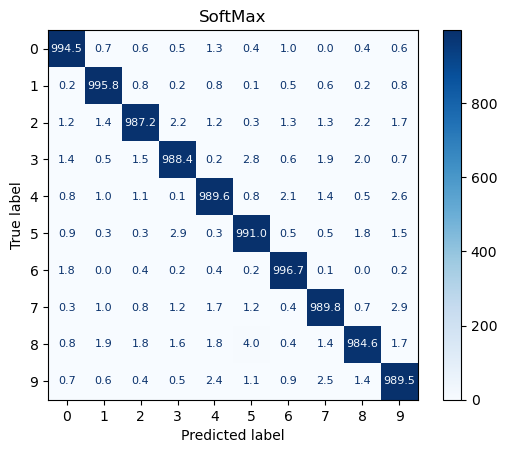

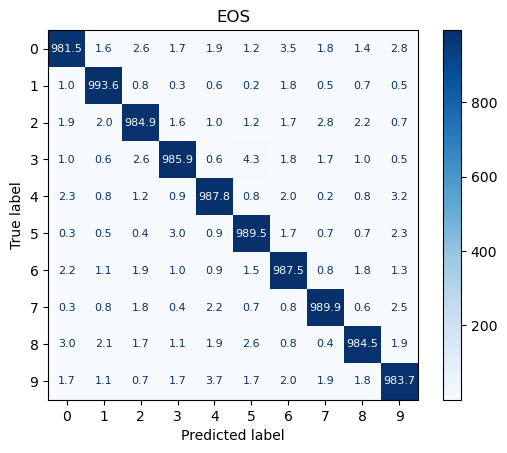

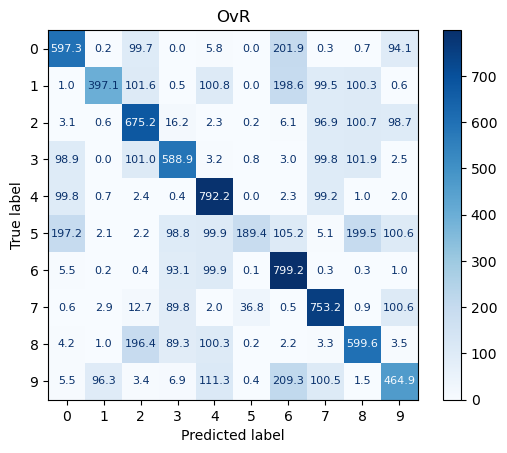

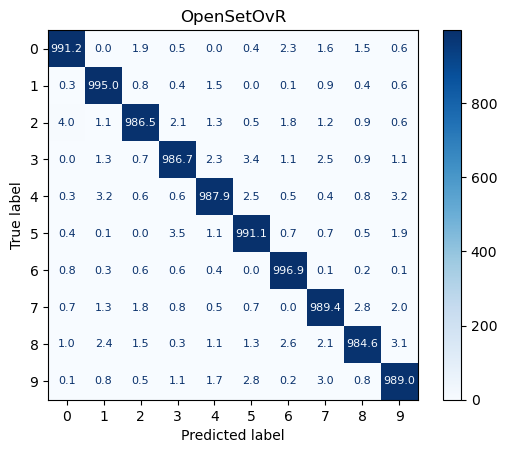

In [44]:
for a in approaches:
    cm_results = None
    for i, s in enumerate(seeds):
        folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
        results = eval_results(folder_path)

        knowns = results.test_neg_gt != -1
        unknowns = ~knowns

        y_true = results.test_neg_gt[knowns]
        y_pred = np.argmax(results.test_neg_probs[knowns], axis=1)

        cm = metrics.confusion_matrix(y_true, y_pred)
        if i == 0:
            cm_results = cm
        else:
            cm_results += cm
    # disp = metrics.ConfusionMatrixDisplay(confusion_matrix=np.round(cm_results/len(seeds), decimals=1))
    cm_results = cm_results / len(seeds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_results)
    disp.plot(cmap=plt.cm.Blues, values_format='.1f')
    for labels in disp.text_.ravel():
        labels.set_fontsize(8)
    plt.title(f"{a}")

## Probability distribution

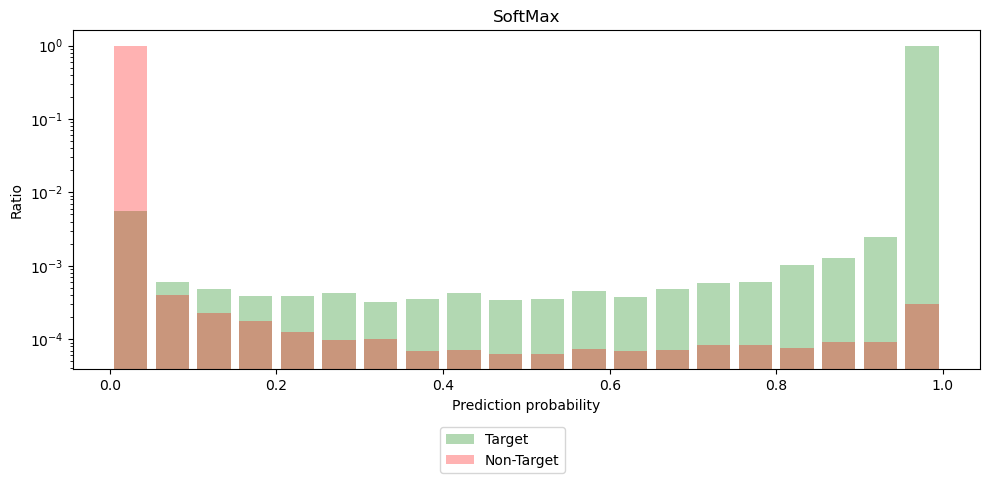

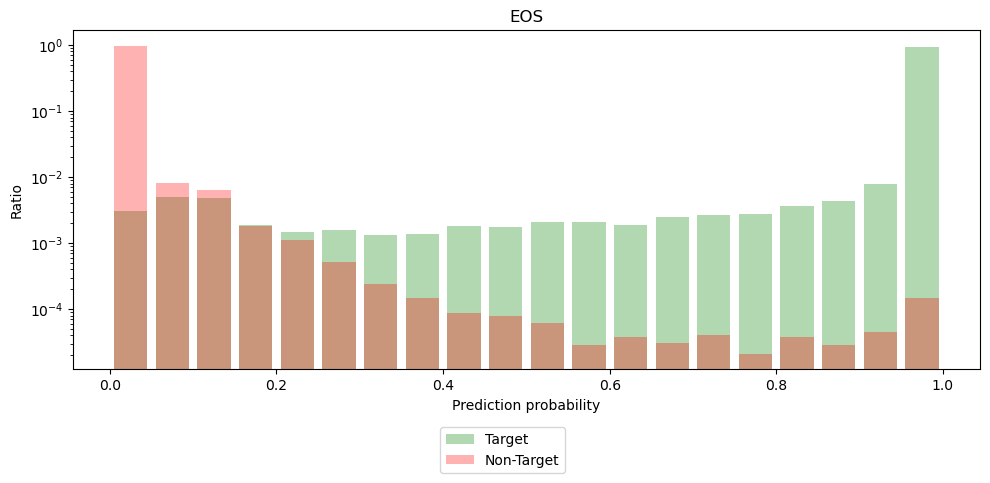

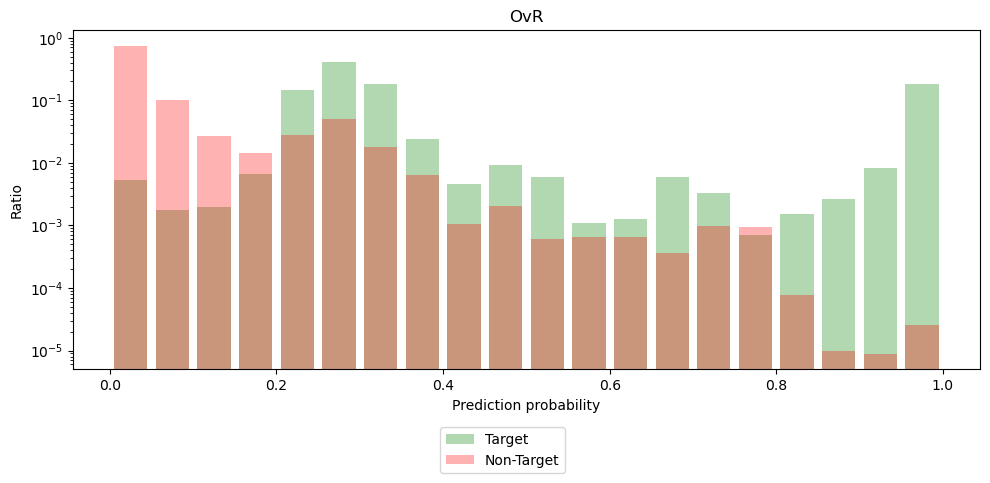

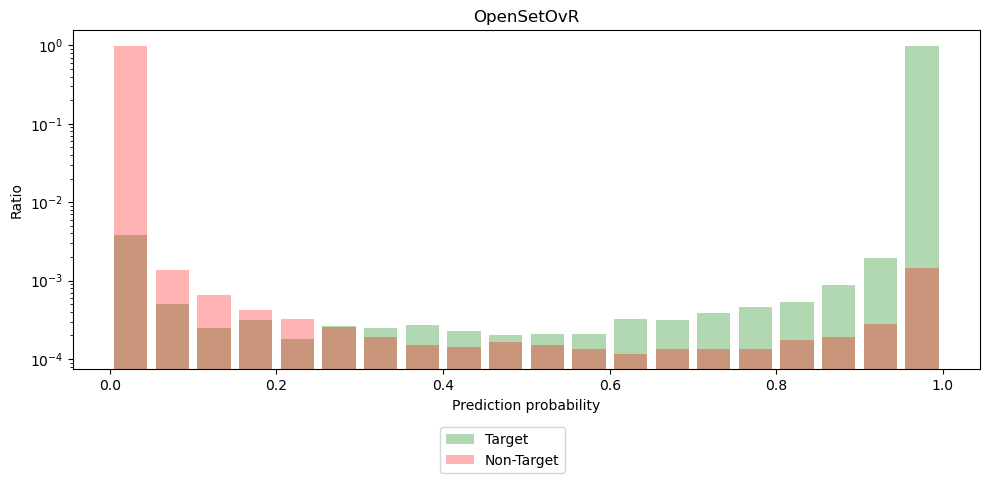

In [45]:
bins = np.linspace(0, 1, 20+1)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

for a in approaches:
    plt.figure(figsize=(10,5))
    target_probs_all = np.array([])
    non_target_probs_all = np.array([])
    for c in range(num_classes):
        for s in seeds:
            folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
            results = eval_results(folder_path)

            # Get known samples in the test set
            knowns = results.test_neg_gt != -1
            test_gt = results.test_neg_gt[knowns]
            test_probs = results.test_neg_probs[knowns]

            # Change to the binary classification problem
            target_probs = test_probs[test_gt == c, :][:,c]
            non_target_probs = test_probs[test_gt != c, :][:,c]

            target_probs_all = np.append(target_probs_all, target_probs)
            non_target_probs_all = np.append(non_target_probs_all, non_target_probs)

    target_probs_all_hist, _ = np.histogram(target_probs_all, bins=bins, density=False)
    non_target_probs_all_hist, _ = np.histogram(non_target_probs_all, bins=bins, density=False)
    target_probs_ratio = target_probs_all_hist/sum(target_probs_all_hist)
    non_target_probs_ratio = non_target_probs_all_hist/sum(non_target_probs_all_hist)

    plt.bar(center, target_probs_ratio, align='center', width=width, color = 'green', alpha = 0.3, label='Target')
    plt.bar(center, non_target_probs_ratio, align='center', width=width, color = 'red', alpha = 0.3, label='Non-Target')

    plt.xlabel('Prediction probability')
    plt.ylabel('Ratio')
    plt.yscale('log')
    plt.title(f"{a}")
    plt.legend(bbox_to_anchor=(.55, -.15))
    plt.tight_layout()
        

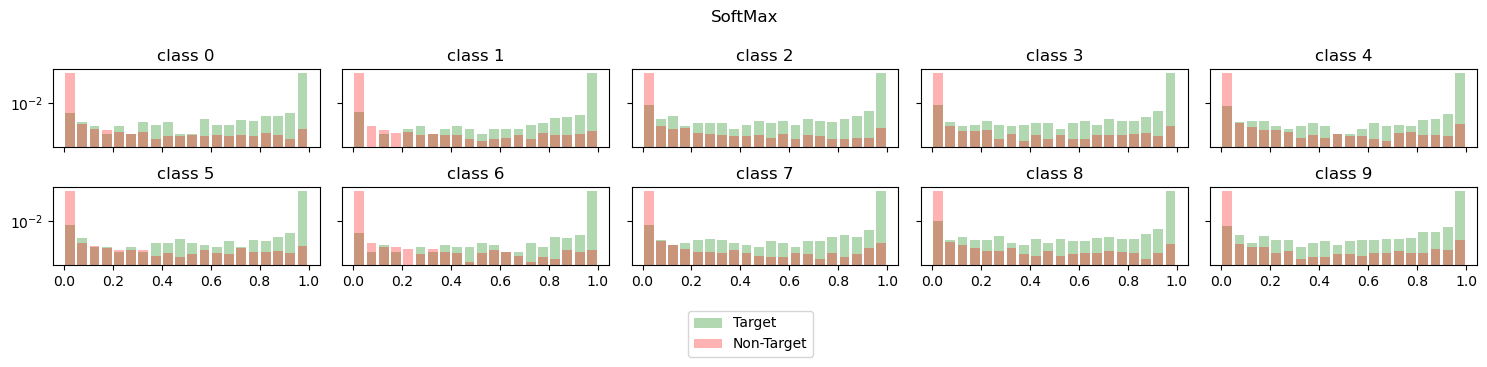

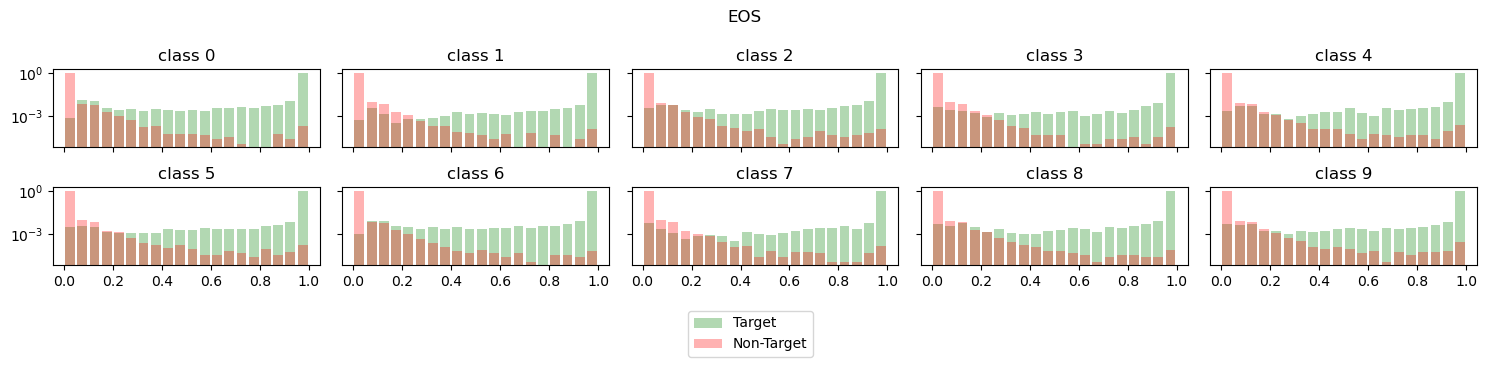

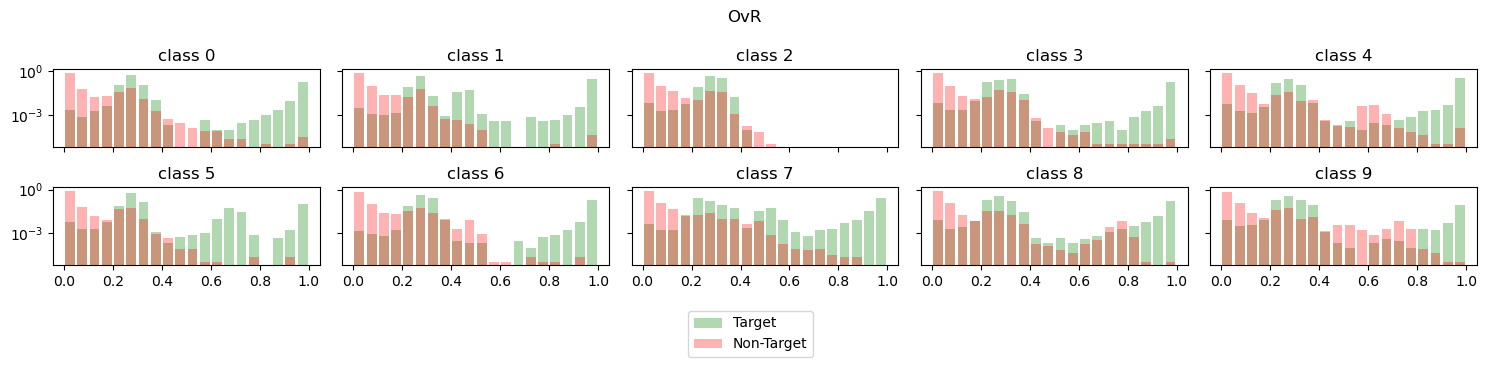

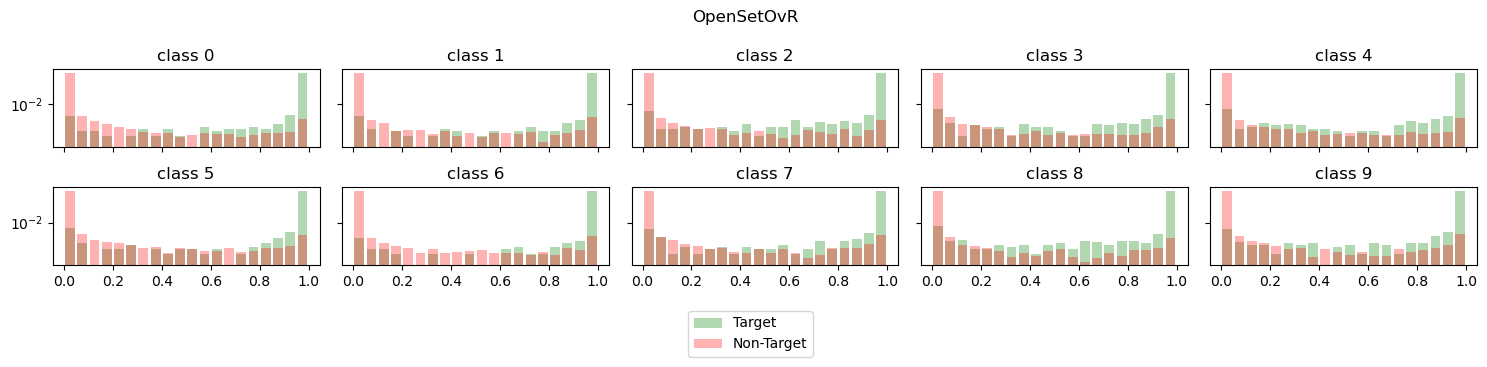

In [46]:
bins = np.linspace(0, 1, 20+1)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

for a in approaches:
    fig, ax = plt.subplots(2,5,figsize=(15,3), sharey=True, sharex=True)
    for c in range(num_classes):
        ax_r, ax_c = int(c/5), int(c%5)
        target_probs_c = np.array([])
        non_target_probs_c = np.array([])
        for s in seeds:
            folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
            results = eval_results(folder_path)

            # Get known samples in the test set
            knowns = results.test_neg_gt != -1
            test_gt = results.test_neg_gt[knowns]
            test_probs = results.test_neg_probs[knowns]

            # Change to the binary classification problem
            target_probs = test_probs[test_gt == c, :][:,c]
            non_target_probs = test_probs[test_gt != c, :][:,c]

            target_probs_c = np.append(target_probs_c, target_probs)
            non_target_probs_c = np.append(non_target_probs_c, non_target_probs)

        target_probs_c_hist, _ = np.histogram(target_probs_c, bins=bins, density=False)
        non_target_probs_c_hist, _ = np.histogram(non_target_probs_c, bins=bins, density=False)
        target_probs_c_ratio = target_probs_c_hist/sum(target_probs_c_hist)
        non_target_probs_c_ratio = non_target_probs_c_hist/sum(non_target_probs_c_hist)

        ax[ax_r,ax_c].bar(center, target_probs_c_ratio, align='center', width=width, color = 'green', alpha = 0.3, label='Target')
        ax[ax_r,ax_c].bar(center, non_target_probs_c_ratio, align='center', width=width, color = 'red', alpha = 0.3, label='Non-Target')
        ax[ax_r,ax_c].set_yscale('log')
        ax[ax_r,ax_c].set_title(f"class {c}")

    handles, labels = ax[ax_r,ax_c].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(.55, 0))
    fig.suptitle(f"{a}")
    fig.tight_layout()
    
        

## OSCR and CCR@FPR

In [33]:
data_info = []

for a in approaches:
    item = {}
    item['info'] = [scale, arch, a]
    item['label'] = approaches_abbr[a]
    item['label_full'] = approaches_full[a]
    data_info.append(item)

In [34]:
results = []
FPR_vals_all = np.linspace(1e-4,1,10**4)
FPR_vals = [1e-4,1e-3,1e-2,1e-1,1]

results = []
for item in data_info:

    info = item['info']
    oscr_neg_res_all, oscr_neg_res = [], []
    oscr_unkn_res_all, oscr_unkn_res = [], []

    for s in seeds:

        ccr, fpr_neg, fpr_unkn = recall_oscr_results(which=info[2], arch=info[1], dataset=info[0], seed = s, is_verbose= s==seeds[0] or s==seeds[-1])

        ccrs_all, _ = CCR_at_FPR(ccr, fpr_neg, FPR_vals_all)
        ccrs, _ = CCR_at_FPR(ccr, fpr_neg, FPR_vals)
        oscr_neg_res_all.append(ccrs_all)
        oscr_neg_res.append(ccrs)

        ccrs_all, _ = CCR_at_FPR(ccr, fpr_unkn, FPR_vals_all)
        ccrs, _ = CCR_at_FPR(ccr, fpr_unkn, FPR_vals)
        oscr_unkn_res_all.append(ccrs_all)
        oscr_unkn_res.append(ccrs)

    results.append([(np.nanmean(oscr_neg_res_all,axis=0), np.nanmean(oscr_neg_res,axis=0), np.nanstd(oscr_neg_res,axis=0)),
                    (np.nanmean(oscr_unkn_res_all,axis=0), np.nanmean(oscr_unkn_res,axis=0), np.nanstd(oscr_unkn_res,axis=0))])

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus/SoftMax/oscr SoftMax
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus/SoftMax/oscr SoftMax
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus/EOS/oscr EOS
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus/EOS/oscr EOS


/tmp/ipykernel_4063809/2691088014.py:27: RuntimeWarning: Mean of empty slice
  (np.nanmean(oscr_unkn_res_all,axis=0), np.nanmean(oscr_unkn_res,axis=0), np.nanstd(oscr_unkn_res,axis=0))])
/home/user/hkim/miniconda3/envs/os-multi-binary/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus/OvR/oscr OvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus/OvR/oscr OvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s42/eval_LeNet_plus_plus/OpenSetOvR/oscr OpenSetOvR
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/_s51/eval_LeNet_plus_plus/OpenSetOvR/oscr OpenSetOvR


In [35]:
results_plot = results
infos_plot = data_info

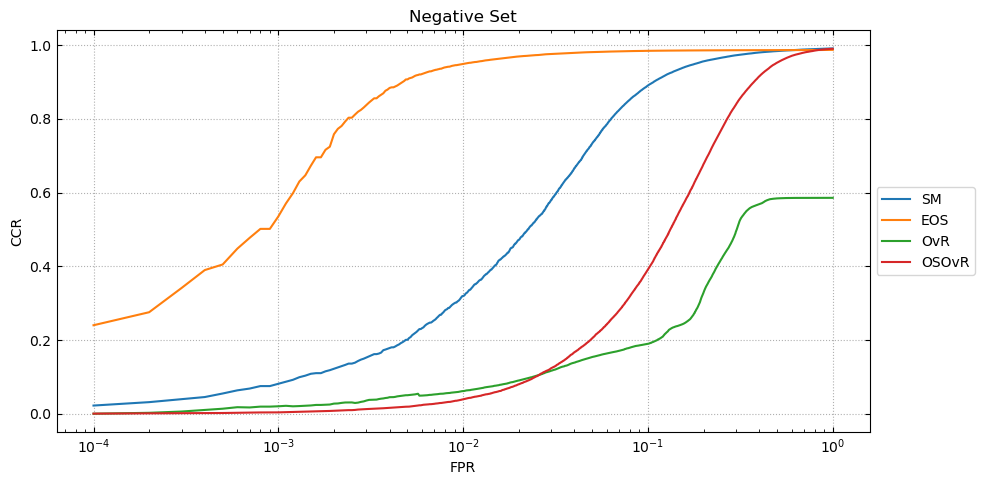

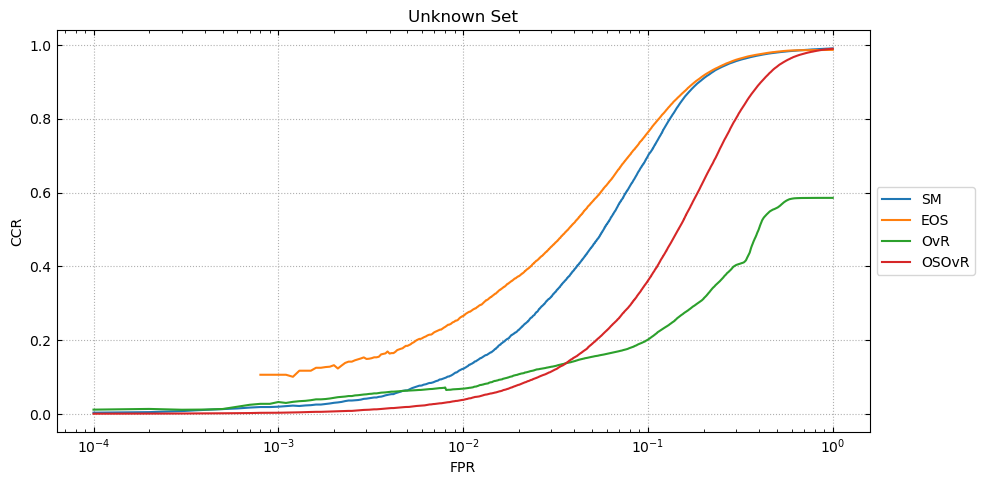

In [36]:
# plot with Negatives
plt.figure(figsize=(10,5))
for idx, res in enumerate(results_plot):
    plt.semilogx(FPR_vals_all, res[0][0], label=infos_plot[idx]['label'], alpha=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.ylabel("CCR")
plt.title("Negative Set")
plt.tight_layout()
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
# plt.savefig(root.joinpath('oscr_neg.png'), bbox_inches="tight") 

# plot with Unknowns
plt.figure(figsize=(10,5))
for idx, res in enumerate(results_plot):
    plt.semilogx(FPR_vals_all, res[1][0], label=infos_plot[idx]['label'], alpha=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.ylabel("CCR")
plt.title("Unknown Set")
plt.tight_layout()
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
# plt.savefig(root.joinpath('oscr_unkn.png'), bbox_inches="tight") 

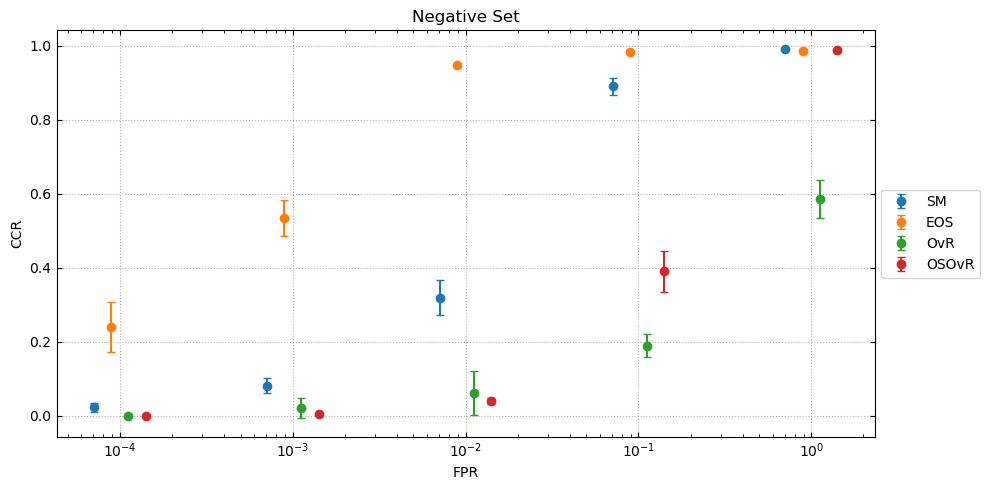

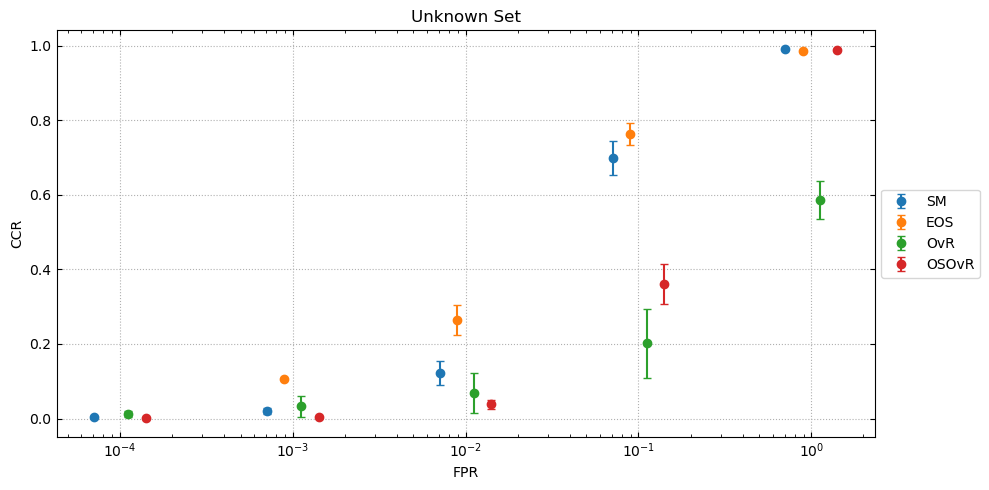

In [37]:
# trans = np.arange(len(results))
# trans = (trans-np.mean(trans))*0.4 + 1

trans = np.arange(len(results_plot)) * 0.1
trans = 10 ** (trans-np.mean(trans))

fig, ax = plt.subplots(figsize=(10,5))
for idx, res in enumerate(results_plot):
    er1 = ax.errorbar([v * trans[idx] for v in FPR_vals], res[0][1], yerr=res[0][2], marker="o", linestyle="none", capsize=3, label=infos_plot[idx]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.xscale('log')
plt.ylabel("CCR")
plt.title("Negative Set")
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for idx, res in enumerate(results_plot):
    er1 = ax.errorbar([v * trans[idx] for v in FPR_vals], res[1][1], yerr=res[1][2], marker="o", linestyle="none", capsize=3, label=infos_plot[idx]['label'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("FPR")
plt.xscale('log')
plt.ylabel("CCR")
plt.title("Unknown Set")
plt.tick_params(direction='in', which='both', top=True, right=True)
plt.grid(which='major', linestyle=':')
plt.tight_layout()


In [38]:
print("CCR@FPR (Testset: Known + Negatives)")
print(*FPR_vals, sep='\t')
for idx, res in enumerate(results_plot):
    print(*[f"{x:.4f}" for x in res[0][1]], sep='\t')
print()
print("CCR@FPR (Testset: Known + Unknowns)")
print(*FPR_vals, sep='\t')
for idx, res in enumerate(results_plot):
    print(*[f"{x:.4f}" for x in res[1][1]], sep='\t')

CCR@FPR (Testset: Known + Negatives)
0.0001	0.001	0.01	0.1	1
0.0225	0.0815	0.3193	0.8903	0.9907
0.2402	0.5352	0.9485	0.9843	0.9869
0.0003	0.0205	0.0616	0.1899	0.5857
0.0006	0.0040	0.0391	0.3907	0.9898

CCR@FPR (Testset: Known + Unknowns)
0.0001	0.001	0.01	0.1	1
0.0034	0.0196	0.1220	0.6988	0.9907
nan	0.1062	0.2650	0.7629	0.9869
0.0117	0.0323	0.0683	0.2012	0.5857
0.0006	0.0032	0.0380	0.3606	0.9898


## Archive

### ROC curve and AUROC value

[sklearn : Multiclass Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-receiver-operating-characteristic-roc)

In [39]:
scale = 'SmallScale'
s = 43
arch = 'LeNet_plus_plus'
a = 'OpenSetOvR'   # SoftMax   EOS     OvR     OpenSetOvR

folder_path = f"./_results/{scale}/_s{s}/eval_{arch}/{a}"
results = eval_results(folder_path)

knowns = results.test_neg_gt != -1
unknowns = ~knowns

y_true = results.test_neg_gt[knowns]
label_binarizer = prep.LabelBinarizer().fit(y_true)
y_onehot_true = label_binarizer.transform(y_true)

y_pred = results.test_neg_probs[knowns]

### Micro-averaged OvR ROC

In [40]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_onehot_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00


### Macro-averaged OvR ROC

In [41]:
for i in range(num_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_onehot_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(num_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
1.00


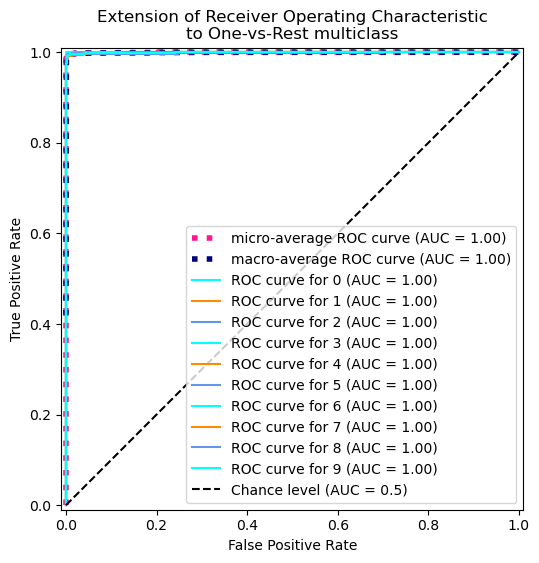

In [42]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(num_classes), colors):
    metrics.RocCurveDisplay.from_predictions(
        y_onehot_true[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {class_id}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == (num_classes-1)),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)